In [1]:
import pandas as pd
import numpy as np
import time

from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 1. Load data
train = pd.read_csv("../gen/data_def_train_folds.csv")
test  = pd.read_csv("../gen/data_def_test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

C:\Users\Voorro\AppData\Local\Temp\ipykernel_35604\1613855081.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("../gen/data_def_train_folds.csv")


Train shape: (206068, 24)
Test shape: (88315, 23)


C:\Users\Voorro\AppData\Local\Temp\ipykernel_35604\1613855081.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  test  = pd.read_csv("../gen/data_def_test.csv")


In [3]:
# 2. Create combined column for Phase 2 (intrinsic + extrinsic)
train["labels_1_2_intr_extr"] = (
    train[["labels_1_intrinsic", "labels_2_extrinsic"]]
    .fillna("")
    .agg("|".join, axis=1)
    .str.strip("|")
)

test["labels_1_2_intr_extr"] = (
    test[["labels_1_intrinsic", "labels_2_extrinsic"]]
    .fillna("")
    .agg("|".join, axis=1)
    .str.strip("|")
)

In [4]:
train.head()

,barcode,product_name,nutriscore,nova_group,mapped_category,labels_string,n_labels_total,labels_1_intrinsic,n_1_intrinsic,labels_2_extrinsic,...,n_additives,n_ingredients,main_mapped_category,label_tier,stratify_raw,stratify,split,nova_group_fold,nutriscore_fold,labels_1_2_intr_extr
0,554004509,Pain de mie sans gluten,c,4,3.1 Bread,NO_GLUTEN|NO_PRESERVATIVES,2,NO_GLUTEN|NO_PRESERVATIVES,2,NaN,...,2.0,22.0,3. Cereals & Starches,1,3. Cereals & Starches | 4,3. Cereals & Starches | 4,train,4,3,NO_GLUTEN|NO_PRESERVATIVES
1,2000002466,2 MINI BAGUETTES SANS GLUTEN,c,4,3.1 Bread,CROSSED_GRAIN|CROSSED_GRAIN_DZG|EU_ORGANIC_LOG...,5,NO_GLUTEN,1,CROSSED_GRAIN|CROSSED_GRAIN_DZG|EU_ORGANIC_LOG...,...,2.0,15.0,3. Cereals & Starches,2,3. Cereals & Starches | 4,3. Cereals & Starches | 4,train,4,3,NO_GLUTEN|CROSSED_GRAIN|CROSSED_GRAIN_DZG|EU_O...
2,2000003197,Véritable Andouille de Guémené,e,4,5.1 Processed meat,SMOKED_BEECH_WOOD,1,SMOKED_BEECH_WOOD,1,NaN,...,2.0,10.0,"5. Meat, Fish & Eggs",1,"5. Meat, Fish & Eggs | 4","5. Meat, Fish & Eggs | 4",train,1,1,SMOKED_BEECH_WOOD
3,2000010775,Escalope soja et blé,b,3,5.4 Meat,EVU_VEGETARIAN|VEGETARIAN,2,NaN,0,EVU_VEGETARIAN|VEGETARIAN,...,0.0,32.0,"5. Meat, Fish & Eggs",1,"5. Meat, Fish & Eggs | 3","5. Meat, Fish & Eggs | 3",train,1,3,EVU_VEGETARIAN|VEGETARIAN
4,8112100281,Pure Sesame Oil,c,2,6.1 Fats & oils,NON_GMO,1,NaN,0,NON_GMO,...,0.0,1.0,6. Fats & Sauces,1,6. Fats & Sauces | 2,6. Fats & Sauces | 2,train,4,4,NON_GMO


In [5]:
test.head()

,barcode,product_name,nutriscore,nova_group,mapped_category,labels_string,n_labels_total,labels_1_intrinsic,n_1_intrinsic,labels_2_extrinsic,...,countries,n_additives,n_ingredients,main_mapped_category,label_tier,stratify_raw,stratify,split,core_slice,labels_1_2_intr_extr
0,790200123,"Fine Chocolate Candy Bar, Dark Chocolate",c,4,9.3 Chocolate products,NO_GLUTEN,1,NO_GLUTEN,1,NaN,...,united-states,2.0,8.0,9. Sweet Products & Desserts,1,9. Sweet Products & Desserts | 4,9. Sweet Products & Desserts | 4,test,False,NO_GLUTEN
1,2000001780,Pizza Margherita,c,3,"7.2 Pizza, pies and quiche",EU_ORGANIC_LOGO,1,NaN,0,EU_ORGANIC_LOGO,...,france,0.0,35.0,7. Composite & Prepared Meals,1,7. Composite & Prepared Meals | 3,7. Composite & Prepared Meals | 3,test,False,EU_ORGANIC_LOGO
2,3004032145,Chinois Nature Décongelé,e,4,9.2 Pastries,UNFROZEN,1,UNFROZEN,1,NaN,...,france,11.0,48.0,9. Sweet Products & Desserts,1,9. Sweet Products & Desserts | 4,9. Sweet Products & Desserts | 4,test,False,UNFROZEN
3,8005158306,"Nuovo Pasta, Organic Ravioli, Butternut Squash",a,4,2.5 Potatoes,EU_ORGANIC_LOGO,1,NaN,0,EU_ORGANIC_LOGO,...,united-states,1.0,33.0,2. Fruits & Vegetables,1,2. Fruits & Vegetables | 4,2. Fruits & Vegetables | 4,test,False,EU_ORGANIC_LOGO
4,8295663177,Balsamic Vinegar Of Modena,c,4,6.2 Dressings and sauces,NON_GMO,1,NaN,0,NON_GMO,...,united-states|world,0.0,3.0,6. Fats & Sauces,1,6. Fats & Sauces | 4,6. Fats & Sauces | 4,test,False,NON_GMO


In [6]:
# 3. Target + folds 
target = "nutriscore" 
fold_col = f"{target}_fold" 

# Encode target variable
le = LabelEncoder()
y_train = le.fit_transform(train[target])
y_test = le.transform(test[target])

print("Class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Class mapping: {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4}


In [7]:
# 4. Define phases (name -> column)
phases = {
    "phase1_intrinsic": "labels_1_intrinsic",
    "phase2_intr+extr": "labels_1_2_intr_extr",
    "phase3_all_labels": "labels_string",
}

all_cv_results = []      # list of per-phase CV results
all_test_results = []    # list of per-phase test metrics


=== phase1_intrinsic – using column 'labels_1_intrinsic' ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['ARTIFICIAL_FLAVOR', 'ENRICHED_WITH_OMEGA3', 'HIGH_IN_CARBOHYDRATES', 'HIGH_IN_OMEGA3_AND_OMEGA6', 'HIGH_IN_PROTEIN_AND_FIBRE', 'HIGH_IN_VITAMIN_K', 'KETOGENIC', 'LOW_FODMAP', 'MINIMALLY_PROCESSED', 'NATURAL_SUGARS_FROM_OATS', 'NATURAL_SUGARS_UNALTERED', 'NOT_FROZEN', 'NO_ADDED_ARTIFICIAL_SWEETENERS', 'NO_ADDITIVES_PRESERVATIVES_COLORANTS', 'NO_ANHYDRIDES', 'NO_AROMA_COLORANT_PRESERVATIVE', 'NO_ARTIFICIAL_DYES', 'NO_ARTIFICIAL_E_NUMBERS', 'NO_ARTIFICIAL_PRESERVATIVES_FLAVOURS_DYES', 'NO_CARRAGEENAN', 'NO_CHEMICAL_INGREDIENTS', 'NO_CHEMICAL_TREATMENT', 'NO_CLEANING_AGENTS', 'NO_COLORANT_AROMA_PRESERVATIVE', 'NO_DYES_PRESERVATIVES_HYDROGENATED_FATS', 'NO_EXTRACTS', 'NO_FRUIT', 'NO_GARLIC_ONION', 'NO_GLUTEN_COLORANT_PRESERVATIVE', 'NO_HIGH_PRESSURE_PROCESSING', 'NO_HONEY', 'NO_LARD', 'NO_METAL_MOLD', 'NO_NUT_TRACES', 'NO_PALM_OIL_DERIVATIVES', 'NO_PHOSPHORIC_ACID', 'NO_POTATO_F

Encoded label matrix shape (train): (206068, 359)
Encoded label matrix shape (test):  (88315, 359)

--- phase1_intrinsic | Fold 1 ---
Accuracy: 0.2973 | Balanced Accuracy: 0.2504 | Fold time: 4.15 s

--- phase1_intrinsic | Fold 2 ---
Accuracy: 0.2977 | Balanced Accuracy: 0.2499 | Fold time: 4.16 s

--- phase1_intrinsic | Fold 3 ---
Accuracy: 0.2982 | Balanced Accuracy: 0.2507 | Fold time: 3.46 s

--- phase1_intrinsic | Fold 4 ---
Accuracy: 0.2970 | Balanced Accuracy: 0.2503 | Fold time: 3.48 s

--- phase1_intrinsic | Fold 5 ---
Accuracy: 0.2961 | Balanced Accuracy: 0.2488 | Fold time: 3.47 s

=== Cross-Validation Summary – phase1_intrinsic ===
   Fold  Accuracy  Balanced Accuracy  Fold Time (s)
0     1  0.297302           0.250350       4.151398
1     2  0.297739           0.249882       4.157314
2     3  0.298248           0.250701       3.464651
3     4  0.297042           0.250270       3.479789
4     5  0.296072           0.248763       3.469816

Mean Accuracy:          0.2973
Mean

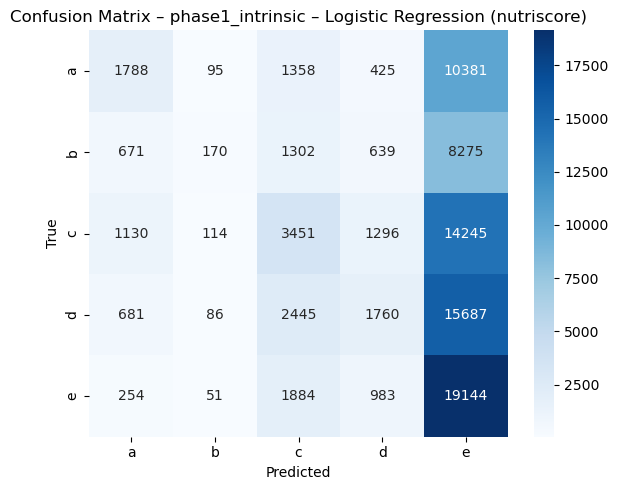


=== phase2_intr+extr – using column 'labels_1_2_intr_extr' ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['ARTIFICIAL_FLAVOR', 'CERT_BIODYNAMIC', 'COASTAL_FISHING', 'DLG_BRONZE_MEDAL', 'ENRICHED_WITH_OMEGA3', 'EU_ORGANIC_CERT_FB', 'EU_ORGANIC_CERT_MY', 'GLUTEN_FREE_VEGAN', 'GLUTEN_LACTOSE_SULFITE_FREE', 'HAZELNUT_FREE', 'HIGH_IN_CARBOHYDRATES', 'HIGH_IN_OMEGA3_AND_OMEGA6', 'HIGH_IN_PROTEIN_AND_FIBRE', 'HIGH_IN_VITAMIN_K', 'INVALID_OR_ERROR', 'ISO_50001', 'KETOGENIC', 'LACTOSE_DAIRY_FREE', 'LOW_FODMAP', 'MAY_CONTAIN_SULPHITES', 'MILK_DERIVATIVE_FREE', 'MINIMALLY_PROCESSED', 'NATURAL_SUGARS_FROM_OATS', 'NATURAL_SUGARS_UNALTERED', 'NOT_FROZEN', 'NO_ADDED_ARTIFICIAL_SWEETENERS', 'NO_ADDITIVES_PRESERVATIVES_COLORANTS', 'NO_ANHYDRIDES', 'NO_ANIMAL_INGREDIENTS', 'NO_AROMA_COLORANT_PRESERVATIVE', 'NO_ARTIFICIAL_DYES', 'NO_ARTIFICIAL_E_NUMBERS', 'NO_ARTIFICIAL_PRESERVATIVES_FLAVOURS_DYES', 'NO_CARRAGEENAN', 'NO_CHEMICAL_INGREDIENTS', 'NO_CHEMICAL_TREATMENT', 'NO_CLEANING_AGENTS', 'NO_COL

Encoded label matrix shape (train): (206068, 808)
Encoded label matrix shape (test):  (88315, 808)

--- phase2_intr+extr | Fold 1 ---
Accuracy: 0.3640 | Balanced Accuracy: 0.3333 | Fold time: 6.76 s

--- phase2_intr+extr | Fold 2 ---
Accuracy: 0.3658 | Balanced Accuracy: 0.3345 | Fold time: 6.70 s

--- phase2_intr+extr | Fold 3 ---
Accuracy: 0.3651 | Balanced Accuracy: 0.3330 | Fold time: 6.31 s

--- phase2_intr+extr | Fold 4 ---
Accuracy: 0.3619 | Balanced Accuracy: 0.3300 | Fold time: 6.50 s

--- phase2_intr+extr | Fold 5 ---
Accuracy: 0.3660 | Balanced Accuracy: 0.3367 | Fold time: 6.53 s

=== Cross-Validation Summary – phase2_intr+extr ===
   Fold  Accuracy  Balanced Accuracy  Fold Time (s)
0     1  0.363978           0.333289       6.757317
1     2  0.365798           0.334516       6.699038
2     3  0.365070           0.333041       6.307505
3     4  0.361949           0.330028       6.499353
4     5  0.365977           0.336675       6.532420

Mean Accuracy:          0.3646
Mean

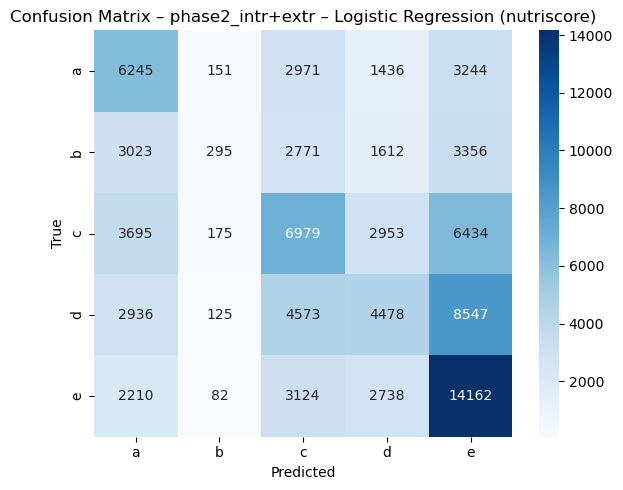


=== phase3_all_labels – using column 'labels_string' ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['ARTIFICIAL_FLAVOR', 'CARREFOUR_CLASSIC', 'CERT_BIODYNAMIC', 'COASTAL_FISHING', 'DLG_BRONZE_MEDAL', 'ENRICHED_WITH_OMEGA3', 'EU_ORGANIC_CERT_FB', 'EU_ORGANIC_CERT_MY', 'GLUTEN_FREE_VEGAN', 'GLUTEN_LACTOSE_SULFITE_FREE', 'GOLD_MEDAL_GENERIC', 'GOLD_MEDAL_MILK_GRADE_A', 'HAZELNUT_FREE', 'HIGH_IN_CARBOHYDRATES', 'HIGH_IN_OMEGA3_AND_OMEGA6', 'HIGH_IN_PROTEIN_AND_FIBRE', 'HIGH_IN_VITAMIN_K', 'INVALID_OR_ERROR', 'ISO_50001', 'KETOGENIC', 'LACTOSE_DAIRY_FREE', 'LOW_FODMAP', 'MAY_CONTAIN_SULPHITES', 'MILK_DERIVATIVE_FREE', 'MINIMALLY_PROCESSED', 'NATURAL_SUGARS_FROM_OATS', 'NATURAL_SUGARS_UNALTERED', 'NOT_FROZEN', 'NO_ADDED_ARTIFICIAL_SWEETENERS', 'NO_ADDITIVES_PRESERVATIVES_COLORANTS', 'NO_ANHYDRIDES', 'NO_ANIMAL_INGREDIENTS', 'NO_AROMA_COLORANT_PRESERVATIVE', 'NO_ARTIFICIAL_DYES', 'NO_ARTIFICIAL_E_NUMBERS', 'NO_ARTIFICIAL_PRESERVATIVES_FLAVOURS_DYES', 'NO_CARRAGEENAN', 'NO_CHEMICA

Encoded label matrix shape (train): (206068, 870)
Encoded label matrix shape (test):  (88315, 870)

--- phase3_all_labels | Fold 1 ---
Accuracy: 0.3707 | Balanced Accuracy: 0.3430 | Fold time: 6.85 s

--- phase3_all_labels | Fold 2 ---
Accuracy: 0.3706 | Balanced Accuracy: 0.3422 | Fold time: 7.32 s

--- phase3_all_labels | Fold 3 ---
Accuracy: 0.3713 | Balanced Accuracy: 0.3424 | Fold time: 6.86 s

--- phase3_all_labels | Fold 4 ---
Accuracy: 0.3688 | Balanced Accuracy: 0.3407 | Fold time: 7.01 s

--- phase3_all_labels | Fold 5 ---
Accuracy: 0.3711 | Balanced Accuracy: 0.3428 | Fold time: 7.14 s

=== Cross-Validation Summary – phase3_all_labels ===
   Fold  Accuracy  Balanced Accuracy  Fold Time (s)
0     1  0.370748           0.342964       6.851853
1     2  0.370602           0.342189       7.317154
2     3  0.371306           0.342395       6.858250
3     4  0.368840           0.340719       7.012443
4     5  0.371121           0.342760       7.136451

Mean Accuracy:          0.370

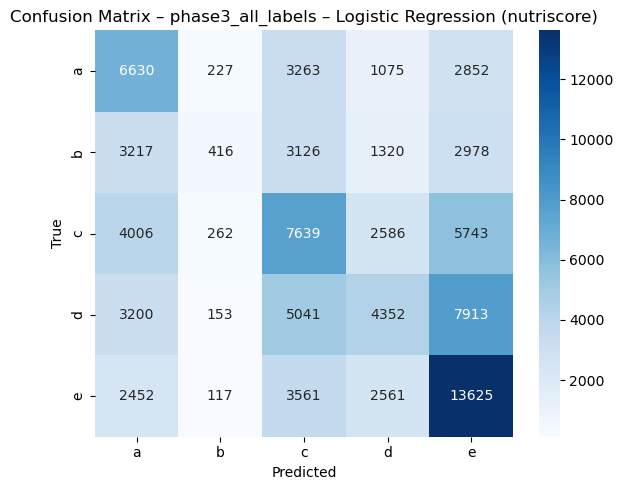

In [8]:
# 5. Loop over phases
for phase_name, label_col in phases.items():
    print("\n" + "="*80)
    print(f"=== {phase_name} – using column '{label_col}' ===")
    print("="*80)

    # 5.1 Prepare label features for this phase
    train[label_col] = train[label_col].fillna("")
    test[label_col]  = test[label_col].fillna("")

    train_labels = train[label_col].apply(lambda x: x.split("|") if x != "" else [])
    test_labels  = test[label_col].apply(lambda x: x.split("|") if x != "" else [])

    mlb = MultiLabelBinarizer(sparse_output=True)
    X_train_labels = mlb.fit_transform(train_labels)
    X_test_labels  = mlb.transform(test_labels)

    print(f"Encoded label matrix shape (train): {X_train_labels.shape}")
    print(f"Encoded label matrix shape (test):  {X_test_labels.shape}")

    # 5.2 Cross-validation over predefined folds
    logreg = LogisticRegression(
        solver='saga',
        random_state=42
    )

    fold_results = []
    cv_start = time.perf_counter()

    for fold in sorted(train[fold_col].unique()):
        print(f"\n--- {phase_name} | Fold {fold} ---")
        
        train_idx = train[train[fold_col] != fold].index
        val_idx   = train[train[fold_col] == fold].index
        
        X_train_fold = X_train_labels[train_idx]
        X_val_fold   = X_train_labels[val_idx]
        y_train_fold = y_train[train_idx]
        y_val_fold   = y_train[val_idx]

        fold_start = time.perf_counter()
        logreg.fit(X_train_fold, y_train_fold)
        y_pred = logreg.predict(X_val_fold)
        fold_end = time.perf_counter()
        fold_time = fold_end - fold_start
        
        acc = accuracy_score(y_val_fold, y_pred)
        bal_acc = balanced_accuracy_score(y_val_fold, y_pred)
        
        print(f"Accuracy: {acc:.4f} | Balanced Accuracy: {bal_acc:.4f} | "
              f"Fold time: {fold_time:.2f} s")
        
        fold_results.append({
            "Phase": phase_name,
            "Fold": fold,
            "Accuracy": acc,
            "Balanced Accuracy": bal_acc,
            "Fold Time (s)": fold_time
        })

    cv_end = time.perf_counter()
    cv_total_time = cv_end - cv_start

    results_df = pd.DataFrame(fold_results)
    all_cv_results.append(results_df)

    print("\n=== Cross-Validation Summary –", phase_name, "===")
    print(results_df[["Fold", "Accuracy", "Balanced Accuracy", "Fold Time (s)"]])
    print(f"\nMean Accuracy:          {results_df['Accuracy'].mean():.4f}")
    print(f"Mean Balanced Accuracy: {results_df['Balanced Accuracy'].mean():.4f}")
    print(f"Total CV time:          {cv_total_time:.2f} s")
    print(f"Mean Fold time:         {results_df['Fold Time (s)'].mean():.2f} s")

    # 5.3 Train on full train, evaluate on test
    logreg_final = LogisticRegression(
        solver='saga',
        random_state=42
    )

    test_train_start = time.perf_counter()
    logreg_final.fit(X_train_labels, y_train)
    test_train_end = time.perf_counter()
    train_time_test_phase = test_train_end - test_train_start

    test_pred_start = time.perf_counter()
    y_pred_test = logreg_final.predict(X_test_labels)
    test_pred_end = time.perf_counter()
    pred_time_test_phase = test_pred_end - test_pred_start

    acc_test = accuracy_score(y_test, y_pred_test)
    bal_acc_test = balanced_accuracy_score(y_test, y_pred_test)
    precision_macro = precision_score(y_test, y_pred_test, average='macro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred_test, average='macro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred_test, average='macro', zero_division=0)
    f1_micro = f1_score(y_test, y_pred_test, average='micro', zero_division=0)

    print(f"\n=== Test Performance – {phase_name} ===")
    print(f"Accuracy:           {acc_test:.4f}")
    print(f"Balanced Accuracy:  {bal_acc_test:.4f}")
    print(f"Precision (Macro):  {precision_macro:.4f}")
    print(f"Recall (Macro):     {recall_macro:.4f}")
    print(f"F1 (Macro):         {f1_macro:.4f}")
    print(f"F1 (Micro):         {f1_micro:.4f}")
    print(f"Train time (test phase):   {train_time_test_phase:.2f} s")
    print(f"Predict time (test phase): {pred_time_test_phase:.2f} s")

    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred_test,
                                target_names=le.classes_, zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix – {phase_name} – Logistic Regression ({target})")
    plt.tight_layout()
    plt.show()

    # Store test metrics + timing for comparison across phases
    all_test_results.append({
        "Phase": phase_name,
        "Accuracy": acc_test,
        "Balanced Accuracy": bal_acc_test,
        "Precision (Macro)": precision_macro,
        "Recall (Macro)": recall_macro,
        "F1 (Macro)": f1_macro,
        "F1 (Micro)": f1_micro,
        "Train Time Test Phase (s)": train_time_test_phase,
        "Predict Time Test Phase (s)": pred_time_test_phase,
        "CV Total Time (s)": cv_total_time,
        "CV Mean Fold Time (s)": results_df["Fold Time (s)"].mean()
    })

In [9]:
# 6. Combine and inspect results across phases
cv_results_all = pd.concat(all_cv_results, ignore_index=True)
test_results_all = pd.DataFrame(all_test_results)

print("\n\n=== All CV Results (all phases) ===")
print(cv_results_all)

print("\n=== Test Results per Phase ===")
print(test_results_all)

# Save results to CSV
cv_results_all.to_csv("../results/logreg_nutri_cv_results_with_time.csv", index=False)
test_results_all.to_csv("../results/logreg_nutri_test_results_with_time.csv", index=False)



=== All CV Results (all phases) ===
                Phase  Fold  Accuracy  Balanced Accuracy  Fold Time (s)
0    phase1_intrinsic     1  0.297302           0.250350       4.151398
1    phase1_intrinsic     2  0.297739           0.249882       4.157314
2    phase1_intrinsic     3  0.298248           0.250701       3.464651
3    phase1_intrinsic     4  0.297042           0.250270       3.479789
4    phase1_intrinsic     5  0.296072           0.248763       3.469816
5    phase2_intr+extr     1  0.363978           0.333289       6.757317
6    phase2_intr+extr     2  0.365798           0.334516       6.699038
7    phase2_intr+extr     3  0.365070           0.333041       6.307505
8    phase2_intr+extr     4  0.361949           0.330028       6.499353
9    phase2_intr+extr     5  0.365977           0.336675       6.532420
10  phase3_all_labels     1  0.370748           0.342964       6.851853
11  phase3_all_labels     2  0.370602           0.342189       7.317154
12  phase3_all_labels     